<a href="https://colab.research.google.com/github/tmedeirosb/modelo_ifrn_integrado/blob/master/PAPER_EXPERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper: XXXX
# Journal: Expert System with Application 

## Abstract: XXXX

O objetivo deste notebook é mostrar que o uso de técnicas de imbalanced learning pode melhorar a acurácia de modelos preditivos de evasão. 

Na primeira parte do paper serão feitos dois modelos: xxx. 

Na segunda parte será utilizada a técnica Balanced Bagging (https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html) com o core DT. 

Para cada modelo serão gerados as métricas: precision, accuracy, recall, ROC, confusion matrix e G-mean. Este último será utilizado para comparação entre modelos como indicado para problemas de dados desbalanceados (https://sci2s.ugr.es/keel/pdf/algorithm/congreso/kubat97addressing.pdf). 

Ao fim é feito o teste de p-value para confirmar se houve diferença estatística entre o desempenho dos modelos

Import packages 

In [0]:
#import packages

#graphs
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()

#google drive
import os
from google.colab import drive

#data crawling
import numpy as np
import pandas as pd

#evalueting models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn.metrics import matthews_corrcoef

#classic models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#imbalanced
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from imblearn.ensemble import BalanceCascade
import operator
from sklearn.base import clone
from imblearn.metrics import geometric_mean_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

from imblearn.pipeline import make_pipeline as make_imb_pipeline

#show graphs in notebook
%matplotlib inline

Import database. The construct the database is available in https://github.com/tmedeirosb/modelo_ifrn_integrado/blob/master/versao_2/workflow_criando_base.ipynb 

In [2]:
#impor database
drive.mount('/content/drive')
dados_tunning = pd.read_json('/content/drive/My Drive/Colab Notebooks/dados/dados_workflow_ivan.json')
dados = dados_tunning.copy()
dados.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(8908, 33)

Functions to pre-process data (remove NaN, dummies transform),  and evaluate the model



In [0]:
#config enviroment
#show all columns
pd.set_option('display.max_columns', None)

#clean the NaN
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)

#plot roc curve
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')
    
#evaluating models
def evaluating(model, ytest, ypred, Xtest):
    #matriz de confusao (AP: atual positivo, AN: atual negativo, PP: pred. positivo, PN: pred. negativo)
    #     AN | AP 
    # --------------
    # PN: TN | FN
    # PP: FP | TP

    #Text summary of the precision, recall, F1 score for each class
    #precision = TP/(TP+FP); TN/(TN+FN) 
    #recall    = TP/(TP+FN); TN/(TN+FP)
    print(classification_report(ytest, ypred))  
    
    print("Matthews correlation coefficient")
    print(matthews_corrcoef(ytest, ypred))
    
    print("G-mean")
    print(geometric_mean_score(ytest, ypred))    
    
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    #tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()    
    #print(tp)
    #print(tn)
    #print(fn)
    #print(fp)
    #print( tn/(tn+fp) )
    
    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print("AUC: %f" % roc_auc_score(ytest, y_scores))
    
def plot_alg_comp(results, names):
  fig = plt.figure()
  fig.suptitle('Algorithm Comparison')
  fig.set_size_inches(11.7, 8.27)
  ax = fig.add_subplot(111)
  plt.boxplot( results )
  ax.set_xticklabels( names )
  plt.xticks(rotation=90)
  plt.show()

#metric recall min
def recall_min(y_true, y_pred):
  tn = confusion_matrix(y_true, y_pred)[0, 0]
  fp = confusion_matrix(y_true, y_pred)[0, 1]
  return tn/(tn+fp)


Function que define os parâmetros dos modelos clássicos (DT, MLP) e do GridSearch, a fim de selecionar o melhor modelo

In [0]:
def select_model(Xtrain, Xtest, ytrain, ytest):
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name":"SVC",
            "estimator":SVC(probability=True, gamma='auto'),
            "hyperparameters":
                {
                  "kernel": ['rbf'],  
                  "C": [0.001, 0.01, 0.1, 1, 10],
                  #"gamma": [0.001, 0.01, 0.1, 1]
                }
        },
        {
            "name": "DecisionTree",
            "estimator": DecisionTreeClassifier(),
            "hyperparameters":
                {
                    "criterion": ["gini", "entropy"],
                    #"min_samples_split": [2],
                    "max_depth": [None, 3, 5],
                    #"min_samples_leaf": [1],
                    "max_leaf_nodes": [None, 5, 10, 20]
                }
        },
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name":"MLP",
            "estimator": MLPClassifier(),
            "hyperparameters":
            {
                'solver': ['lbfgs'], 
                'max_iter': [200],
                'alpha': 10.0 ** -np.arange(1, 4), 
                'hidden_layer_sizes':np.arange(5, 20, 3), 
                'random_state':[0]
            }            
        },
        {
            "name": "RF",
            "estimator": RandomForestClassifier(),
            "hyperparameters":
                {
                    "max_features": ["auto"],
                    'n_estimators': [10, 30, 100, 200, 300]
                }
        }
    ]      
   
    results = []
    names = []    
         
    #for each model traing and evaluating
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        #find best param
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, 
                            verbose=1,
                            n_jobs = -1,
                            scoring=make_scorer(geometric_mean_score))
                            #scoring='recall_macro')
                            #scoring='accuracy')
                            #scoring=make_scorer(recall_min))
        
        grid.fit(Xtrain, ytrain)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))
                
    return models

Define os atributos da base de dados e, caso ainda tenha valores NAN, substituti por -1

In [5]:
#select attributes
atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

#fill NAN
dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#use original data
dados = dados[dados.artificial == 0]

print(dados.classe.value_counts())

dados.head(2)

1    7369
0     349
Name: classe, dtype: int64


,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,15,F,False,0,1,2,LAJ,1
10,61.0,0,100.0,60.0,0,100.0,0,False,0,1,B,A,Urbana,Pais,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino médio completo,Ensino médio completo,Parda,Ensino médio completo,Mãe,Não informado,15,M,True,0,2,5,CANG,2


Separa os dados em 25% de teste e 75% de treino. Os dois folds são estratificados de acordo com o balanceamento da classe de evasão, a fim de manter a proporção dos dados do conjunto original. 

Esse conjunto de dados será utilizado em todos os modelos

In [6]:
#split data test and training. Stratify like imbalanced classes
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42, stratify = y)

(7718, 31)
(7718, 31)
(7718, 151)


## Treina os modelos clássicos (MLP, DT, SVM, LOGISTIC)

In [7]:
res_models = select_model(Xtrain, Xtest, ytrain, ytest)

SVC
---
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.8min finished


Best Score: 0.5397766867631527
Best Parameters: {'C': 10, 'kernel': 'rbf'}
DecisionTree
------------
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   19.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Score: 0.6611201507410824
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': None}
LogisticRegression
------------------
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.4s finished


Best Score: 0.5368841192922973
Best Parameters: {'solver': 'newton-cg'}
MLP
---
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.9min finished


Best Score: 0.5258980383231664
Best Parameters: {'alpha': 0.01, 'hidden_layer_sizes': 17, 'max_iter': 200, 'random_state': 0, 'solver': 'lbfgs'}
RF
--
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.7s


Best Score: 0.5707465755734764
Best Parameters: {'max_features': 'auto', 'n_estimators': 10}


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.4s finished


Avalia os modelos clássicos. 



SVC
---
              precision    recall  f1-score   support

           0       0.62      0.36      0.45        87
           1       0.97      0.99      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.80      0.67      0.72      1930
weighted avg       0.95      0.96      0.96      1930

Matthews correlation coefficient
0.4519082102866017
G-mean
0.5938420817515476


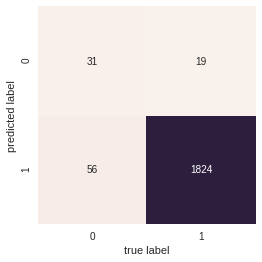

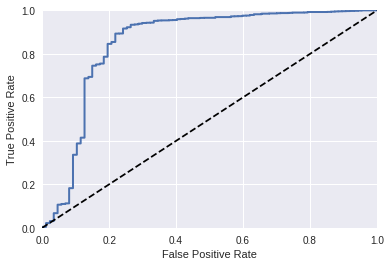

AUC: 0.850391
Mean G-MEAN do conjunto de testes: 0.504300 (0.188954) 



DecisionTree
------------
              precision    recall  f1-score   support

           0       0.45      0.56      0.50        87
           1       0.98      0.97      0.97      1843

   micro avg       0.95      0.95      0.95      1930
   macro avg       0.72      0.77      0.74      1930
weighted avg       0.96      0.95      0.95      1930

Matthews correlation coefficient
0.4795111225872309
G-mean
0.7383685176998162


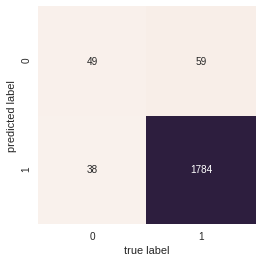

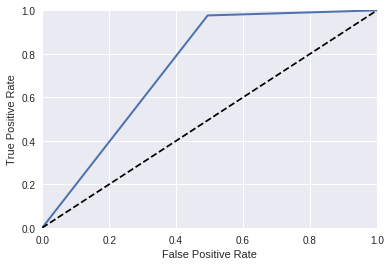

AUC: 0.741208
Mean G-MEAN do conjunto de testes: 0.711353 (0.146431) 



LogisticRegression
------------------
              precision    recall  f1-score   support

           0       0.72      0.38      0.50        87
           1       0.97      0.99      0.98      1843

   micro avg       0.97      0.97      0.97      1930
   macro avg       0.84      0.69      0.74      1930
weighted avg       0.96      0.97      0.96      1930

Matthews correlation coefficient
0.5063436500970249
G-mean
0.6137057903333687


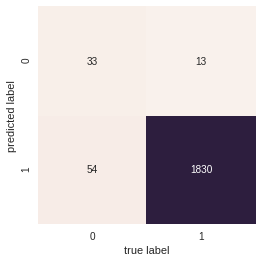

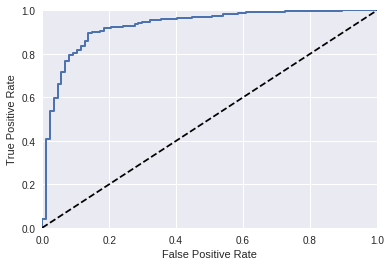

AUC: 0.928215
Mean G-MEAN do conjunto de testes: 0.637652 (0.097641) 



MLP
---
              precision    recall  f1-score   support

           0       0.66      0.29      0.40        87
           1       0.97      0.99      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.81      0.64      0.69      1930
weighted avg       0.95      0.96      0.95      1930

Matthews correlation coefficient
0.41859791767234406
G-mean
0.5341623271383589


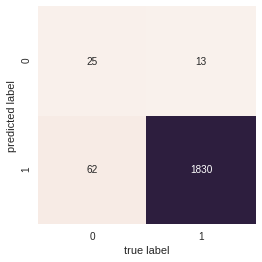

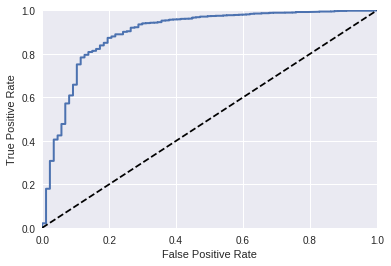

AUC: 0.896698
Mean G-MEAN do conjunto de testes: 0.573940 (0.195244) 



RF
--
              precision    recall  f1-score   support

           0       0.74      0.36      0.48        87
           1       0.97      0.99      0.98      1843

   micro avg       0.97      0.97      0.97      1930
   macro avg       0.85      0.68      0.73      1930
weighted avg       0.96      0.97      0.96      1930

Matthews correlation coefficient
0.4981990304567432
G-mean
0.5951429421970741


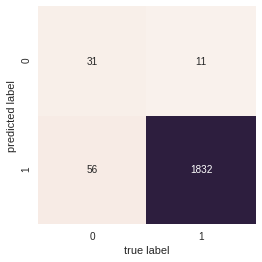

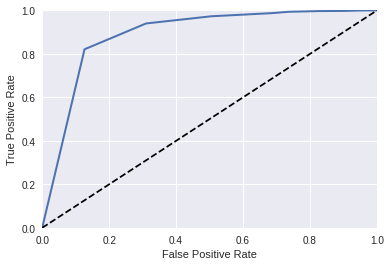

AUC: 0.890087
Mean G-MEAN do conjunto de testes: 0.499266 (0.195213) 



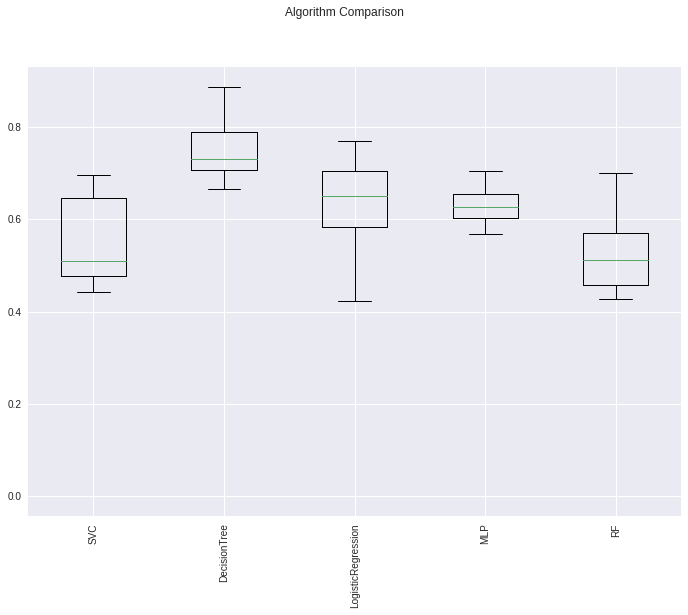

In [8]:
kfold = model_selection.KFold(n_splits=10, random_state=42)

results = []
names = []    

#avaliacao individual por modelo
for model in res_models:        
    print('\n\n'+model['name'])
    print('-'*len(model['name']))

    #sim
    ypred = model['best_model'].predict(Xtest)
    evaluating(model['best_model'], ytest, ypred, Xtest)
    
    #boxplot
    #testa 10 vezes o modelo, a fim de gerar estatística para ser avaliado no p-value
    #cv_results = model_selection.cross_val_score(model["best_model"], Xtest, ytest, cv=kfold, scoring='recall_macro') #scoring='accuracy')
    cv_results = model_selection.cross_val_score(model["best_model"], Xtest, ytest, cv=kfold, scoring=make_scorer(geometric_mean_score))
    model['cv_results'] = cv_results
    results.append(cv_results)
    names.append(model['name'])
    msg = "Mean G-MEAN do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
plot_alg_comp(results, names)

SVC
Under Sample
---
              precision    recall  f1-score   support

           0       0.20      0.77      0.31        87
           1       0.99      0.85      0.91      1843

   micro avg       0.85      0.85      0.85      1930
   macro avg       0.59      0.81      0.61      1930
weighted avg       0.95      0.85      0.89      1930

Matthews correlation coefficient
0.33737029666885454
G-mean
0.8094464758915092


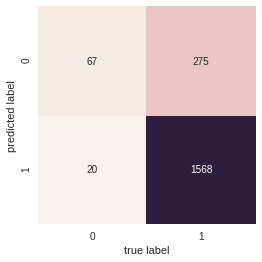

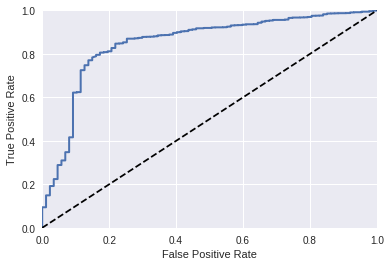

AUC: 0.849433
Score do conjunto de testes: 0.923771 (0.022308) 



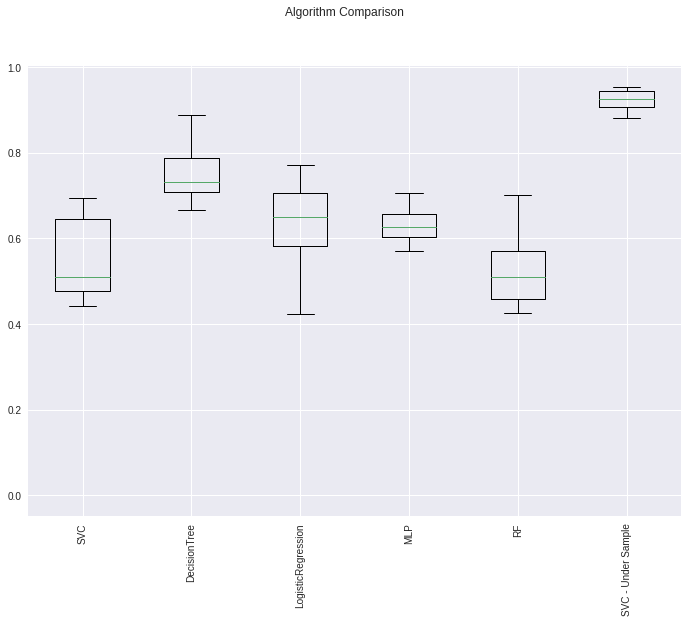

DecisionTree
Under Sample
------------
              precision    recall  f1-score   support

           0       0.17      0.83      0.29        87
           1       0.99      0.81      0.89      1843

   micro avg       0.82      0.82      0.82      1930
   macro avg       0.58      0.82      0.59      1930
weighted avg       0.95      0.82      0.87      1930

Matthews correlation coefficient
0.3245043601649284
G-mean
0.8209832572650692


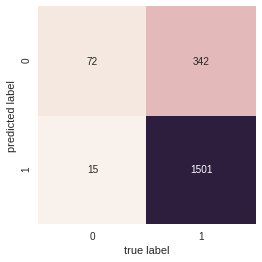

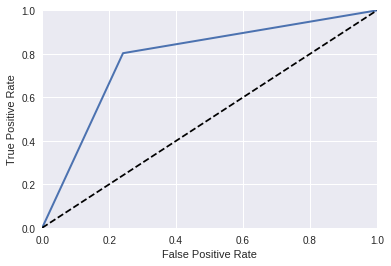

AUC: 0.780830
Score do conjunto de testes: 0.948708 (0.019783) 



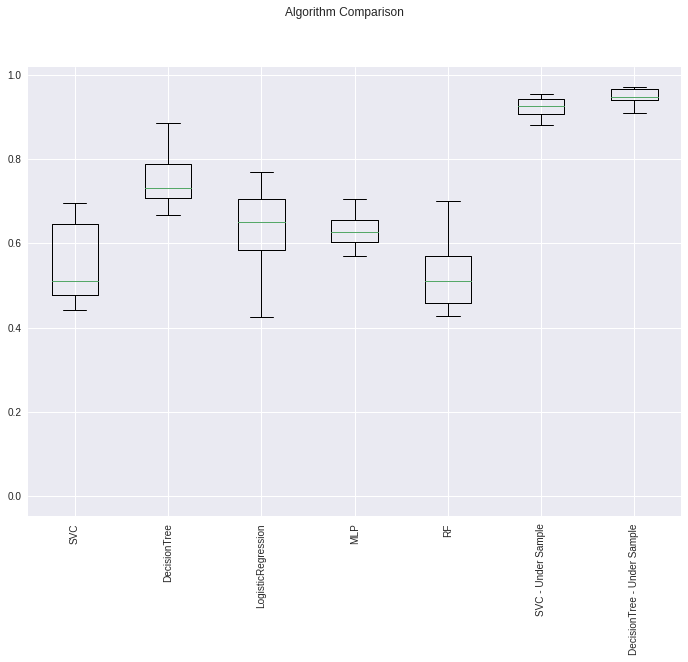

LogisticRegression
Under Sample
------------------
              precision    recall  f1-score   support

           0       0.24      0.87      0.38        87
           1       0.99      0.87      0.93      1843

   micro avg       0.87      0.87      0.87      1930
   macro avg       0.62      0.87      0.65      1930
weighted avg       0.96      0.87      0.90      1930

Matthews correlation coefficient
0.4151257557076319
G-mean
0.8711243795002996


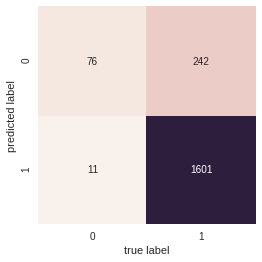

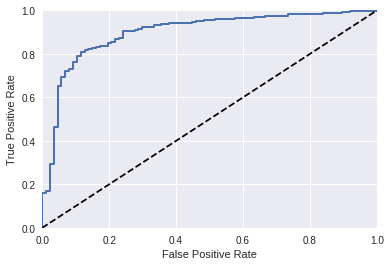

AUC: 0.898965
Score do conjunto de testes: 0.963186 (0.021321) 



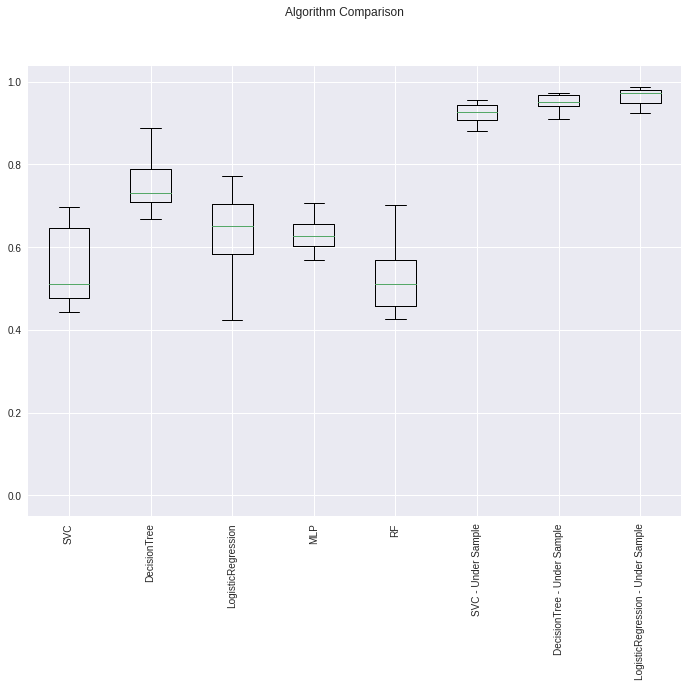

MLP
Under Sample
---
              precision    recall  f1-score   support

           0       0.22      0.82      0.35        87
           1       0.99      0.87      0.92      1843

   micro avg       0.86      0.86      0.86      1930
   macro avg       0.61      0.84      0.64      1930
weighted avg       0.96      0.86      0.90      1930

Matthews correlation coefficient
0.38146615647914917
G-mean
0.8406656919047433


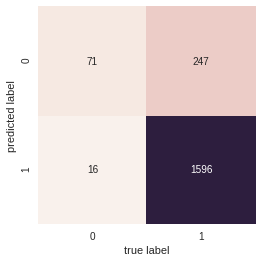

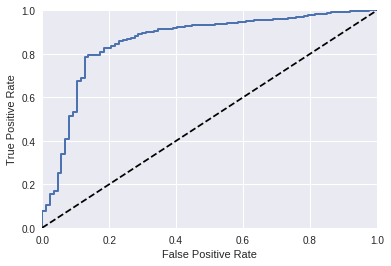

AUC: 0.858508
Score do conjunto de testes: 0.922345 (0.031763) 



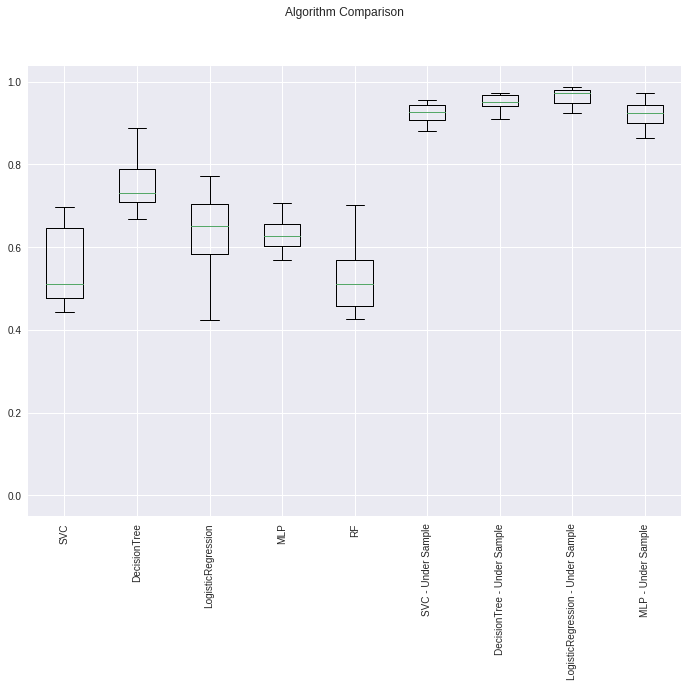

RF
Under Sample
--
              precision    recall  f1-score   support

           0       0.19      0.92      0.32        87
           1       1.00      0.82      0.90      1843

   micro avg       0.82      0.82      0.82      1930
   macro avg       0.59      0.87      0.61      1930
weighted avg       0.96      0.82      0.87      1930

Matthews correlation coefficient
0.37197604507853077
G-mean
0.8671202444954681


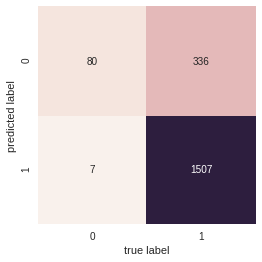

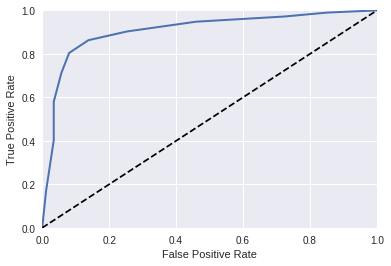

AUC: 0.907070
Score do conjunto de testes: 0.881731 (0.029756) 



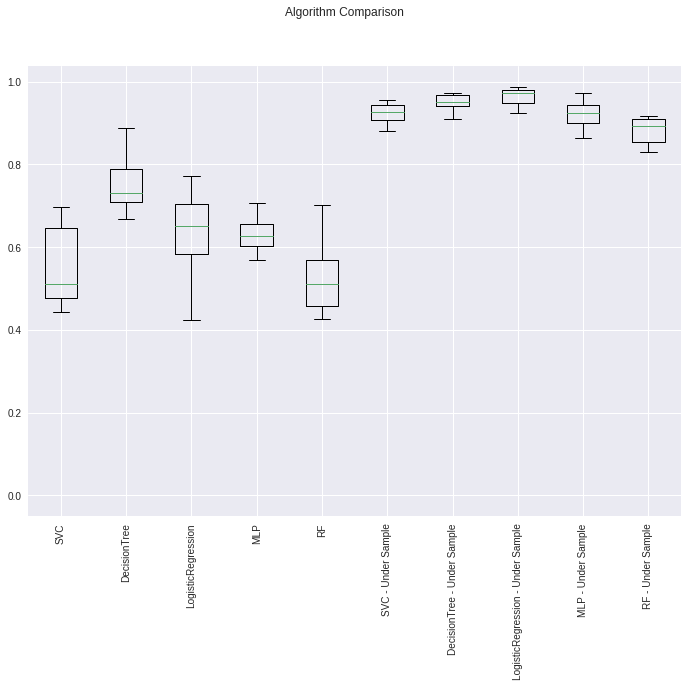

SVC
Over Sample
---
              precision    recall  f1-score   support

           0       0.55      0.36      0.43        87
           1       0.97      0.99      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.76      0.67      0.71      1930
weighted avg       0.95      0.96      0.95      1930

Matthews correlation coefficient
0.42367205475125747
G-mean
0.5928645632587836


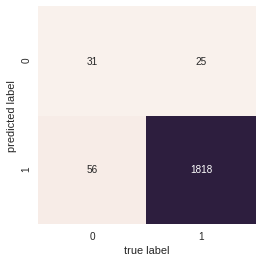

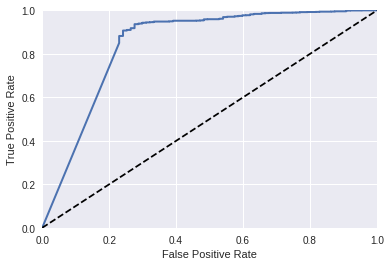

AUC: 0.845523
Score do conjunto de testes: 0.606340 (0.154935) 



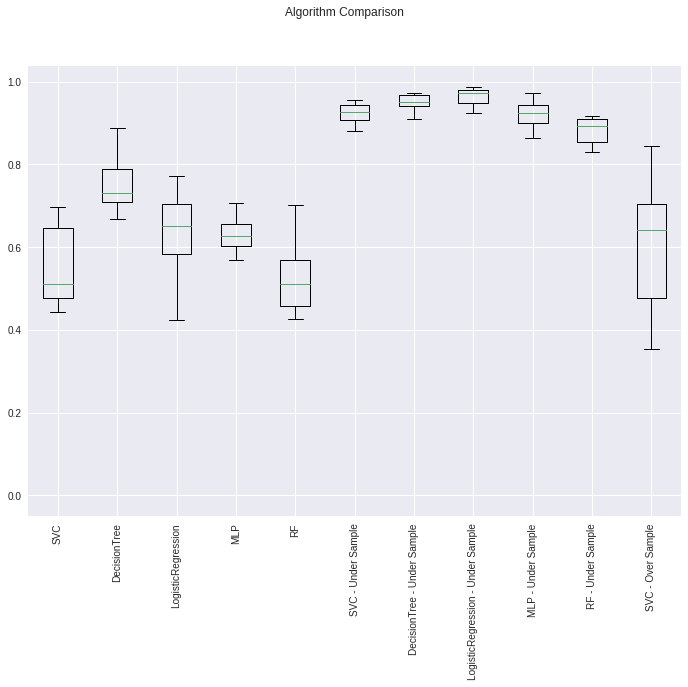

DecisionTree
Over Sample
------------
              precision    recall  f1-score   support

           0       0.55      0.55      0.55        87
           1       0.98      0.98      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.76      0.77      0.76      1930
weighted avg       0.96      0.96      0.96      1930

Matthews correlation coefficient
0.5271433419320086
G-mean
0.734676567300357


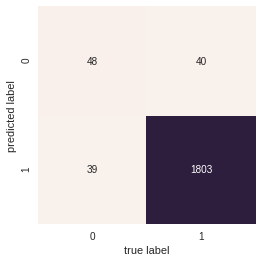

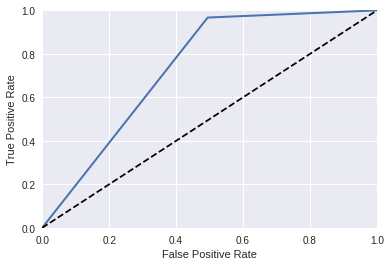

AUC: 0.736324
Score do conjunto de testes: 0.727278 (0.127787) 



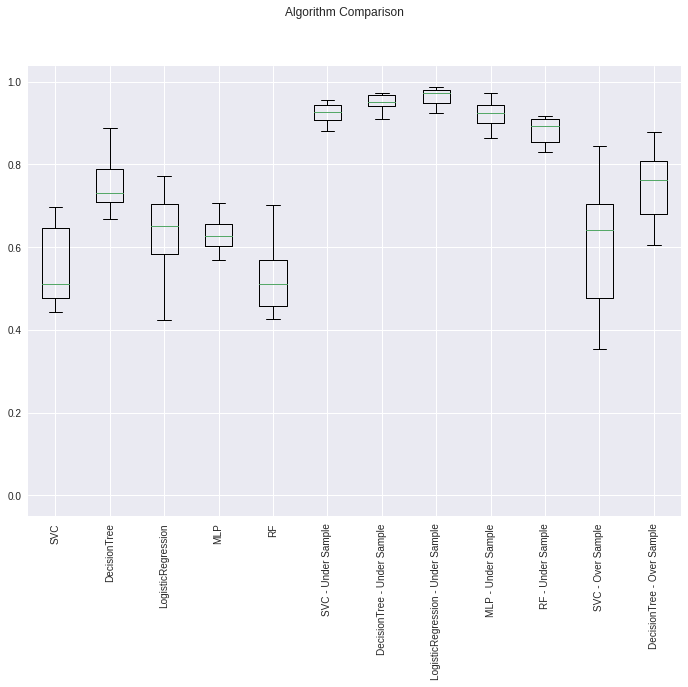

LogisticRegression
Over Sample
------------------
              precision    recall  f1-score   support

           0       0.24      0.82      0.37        87
           1       0.99      0.88      0.93      1843

   micro avg       0.88      0.88      0.88      1930
   macro avg       0.62      0.85      0.65      1930
weighted avg       0.96      0.88      0.91      1930

Matthews correlation coefficient
0.40220392339851163
G-mean
0.847224269172073


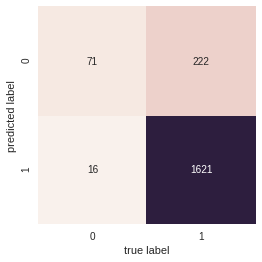

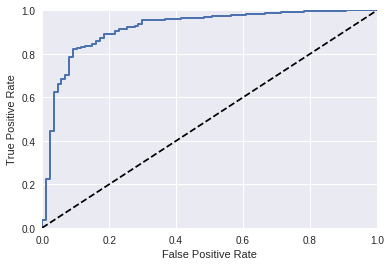

AUC: 0.918193
Score do conjunto de testes: 0.950421 (0.020465) 



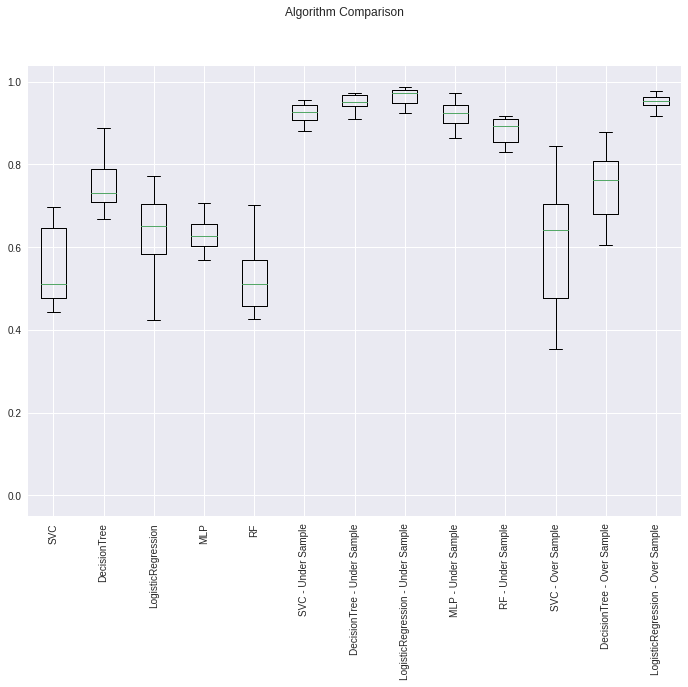

MLP
Over Sample
---
              precision    recall  f1-score   support

           0       0.24      0.83      0.38        87
           1       0.99      0.88      0.93      1843

   micro avg       0.88      0.88      0.88      1930
   macro avg       0.62      0.85      0.65      1930
weighted avg       0.96      0.88      0.91      1930

Matthews correlation coefficient
0.4065209599211066
G-mean
0.8526432900186605


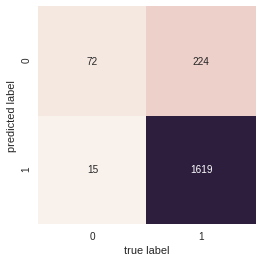

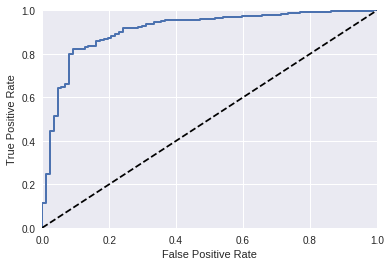

AUC: 0.910884
Score do conjunto de testes: 0.928375 (0.023802) 



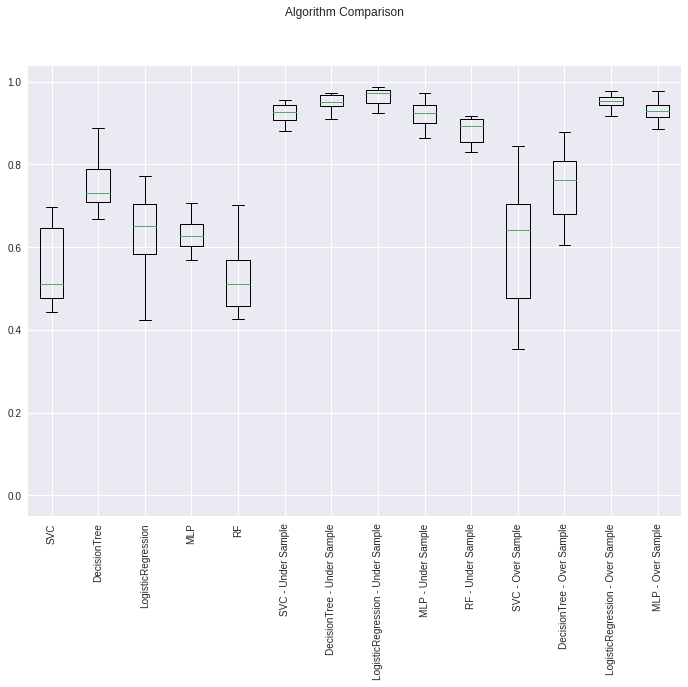

RF
Over Sample
--
              precision    recall  f1-score   support

           0       0.66      0.59      0.62        87
           1       0.98      0.99      0.98      1843

   micro avg       0.97      0.97      0.97      1930
   macro avg       0.82      0.79      0.80      1930
weighted avg       0.97      0.97      0.97      1930

Matthews correlation coefficient
0.6064720096820119
G-mean
0.7602216924834847


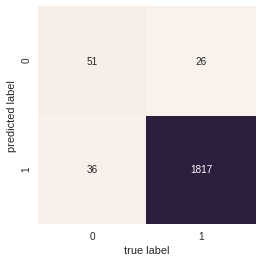

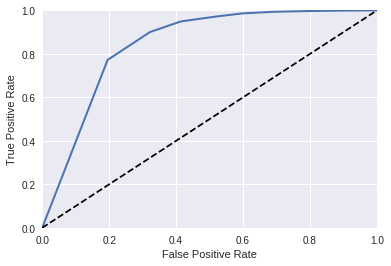

AUC: 0.844796
Score do conjunto de testes: 0.804105 (0.106943) 



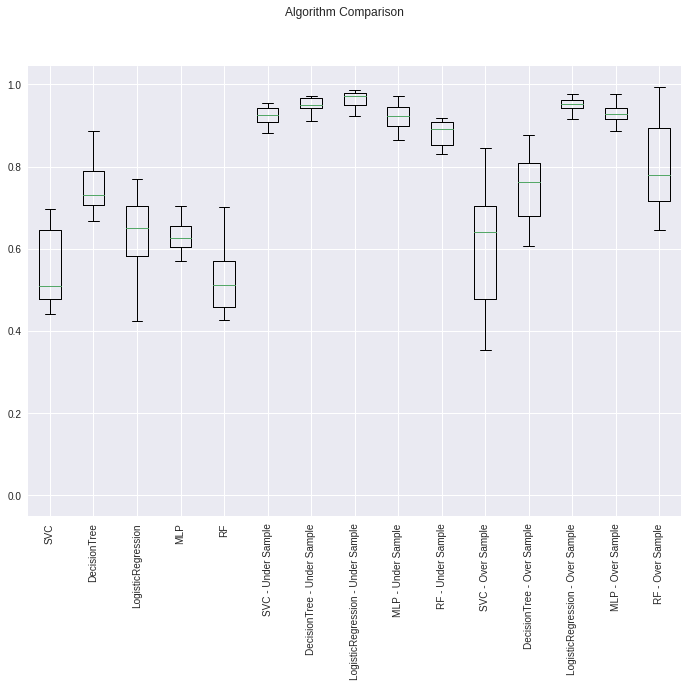

SVC
SMOTE
---
              precision    recall  f1-score   support

           0       0.52      0.41      0.46        87
           1       0.97      0.98      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.75      0.70      0.72      1930
weighted avg       0.95      0.96      0.95      1930

Matthews correlation coefficient
0.4423808995872639
G-mean
0.6374824658962939


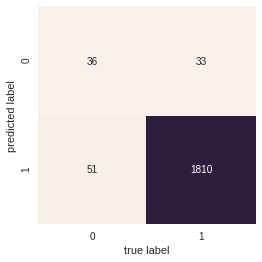

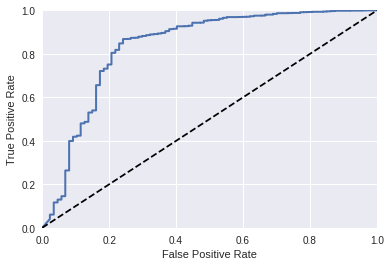

AUC: 0.834578
Score do conjunto de testes: 0.672542 (0.088387) 



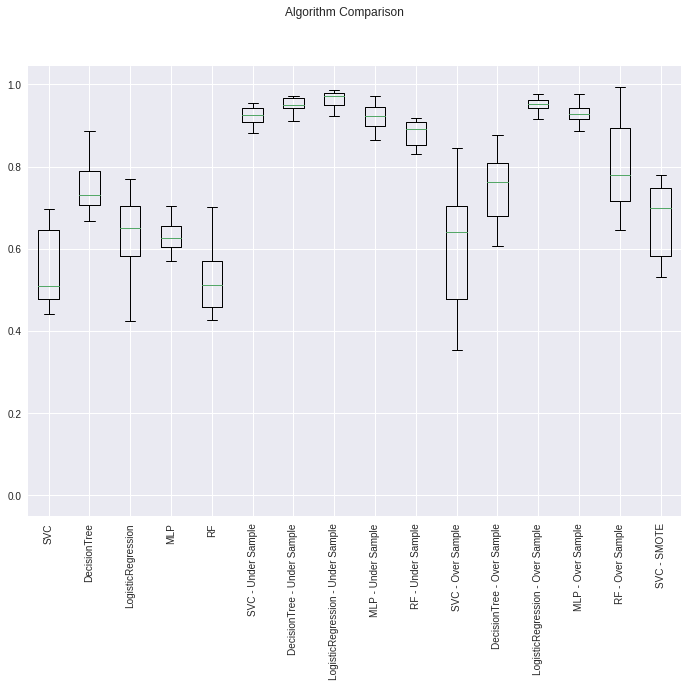

DecisionTree
SMOTE
------------
              precision    recall  f1-score   support

           0       0.55      0.54      0.55        87
           1       0.98      0.98      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.77      0.76      0.76      1930
weighted avg       0.96      0.96      0.96      1930

Matthews correlation coefficient
0.5254038570064223
G-mean
0.7273865028585713


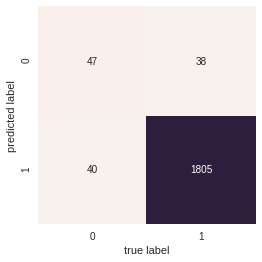

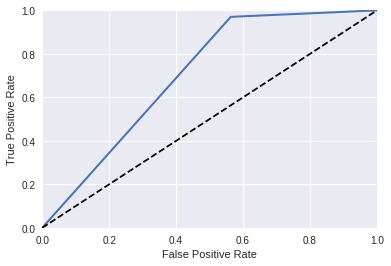

AUC: 0.703469
Score do conjunto de testes: 0.715346 (0.121774) 



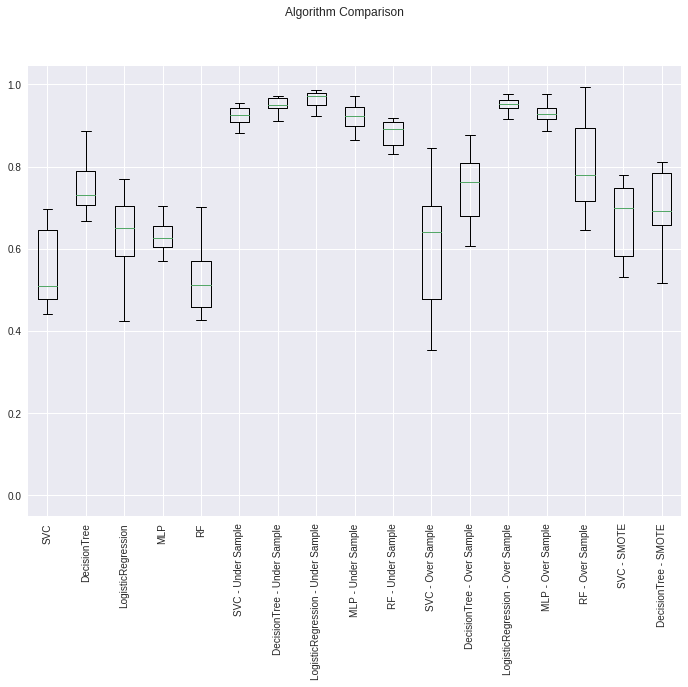

LogisticRegression
SMOTE
------------------
              precision    recall  f1-score   support

           0       0.25      0.79      0.38        87
           1       0.99      0.89      0.93      1843

   micro avg       0.88      0.88      0.88      1930
   macro avg       0.62      0.84      0.66      1930
weighted avg       0.96      0.88      0.91      1930

Matthews correlation coefficient
0.4006987460671353
G-mean
0.8382920428606195


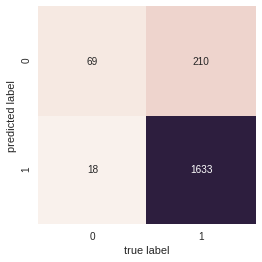

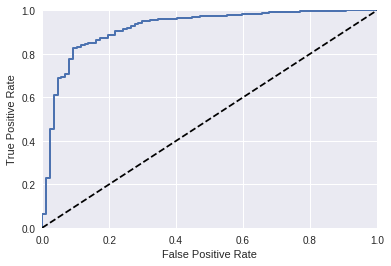

AUC: 0.920008
Score do conjunto de testes: 0.945310 (0.023598) 



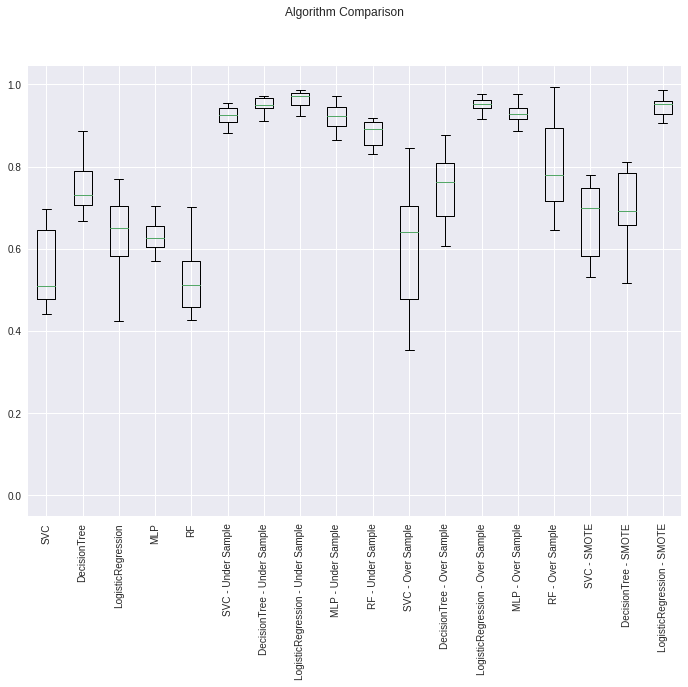

MLP
SMOTE
---
              precision    recall  f1-score   support

           0       0.25      0.77      0.38        87
           1       0.99      0.89      0.94      1843

   micro avg       0.89      0.89      0.89      1930
   macro avg       0.62      0.83      0.66      1930
weighted avg       0.95      0.89      0.91      1930

Matthews correlation coefficient
0.3966213434008933
G-mean
0.8283267445137299


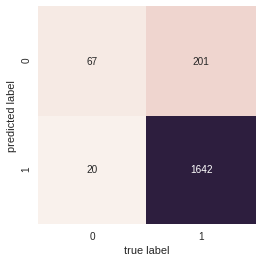

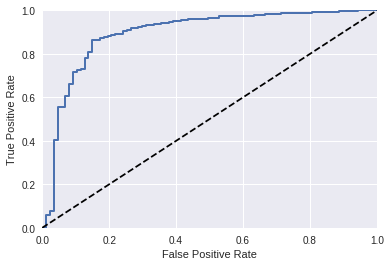

AUC: 0.893901
Score do conjunto de testes: 0.934665 (0.025702) 



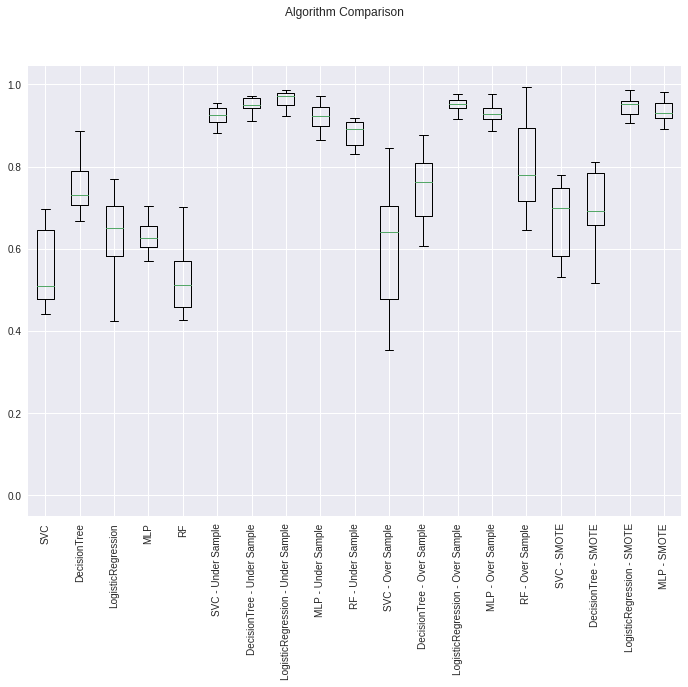

RF
SMOTE
--
              precision    recall  f1-score   support

           0       0.56      0.32      0.41        87
           1       0.97      0.99      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.76      0.65      0.69      1930
weighted avg       0.95      0.96      0.95      1930

Matthews correlation coefficient
0.4047461962714715
G-mean
0.5639124651237006


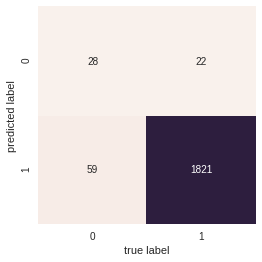

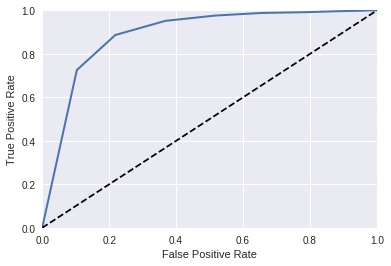

AUC: 0.889698
Score do conjunto de testes: 0.406427 (0.276415) 



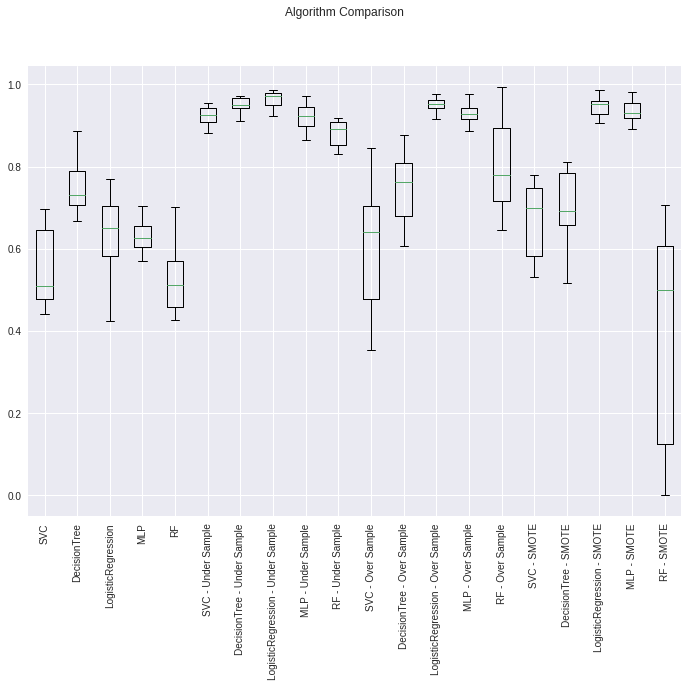

SVC
SMOTEENN
---
              precision    recall  f1-score   support

           0       0.31      0.55      0.40        87
           1       0.98      0.94      0.96      1843

   micro avg       0.92      0.92      0.92      1930
   macro avg       0.64      0.75      0.68      1930
weighted avg       0.95      0.92      0.93      1930

Matthews correlation coefficient
0.3784001441443926
G-mean
0.7211045468899908


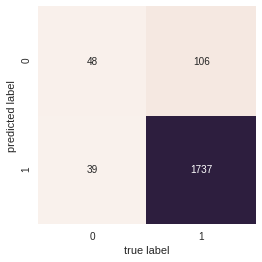

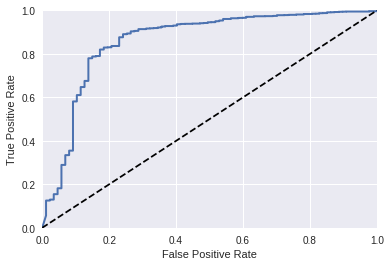

AUC: 0.860398
Score do conjunto de testes: 0.864661 (0.053346) 



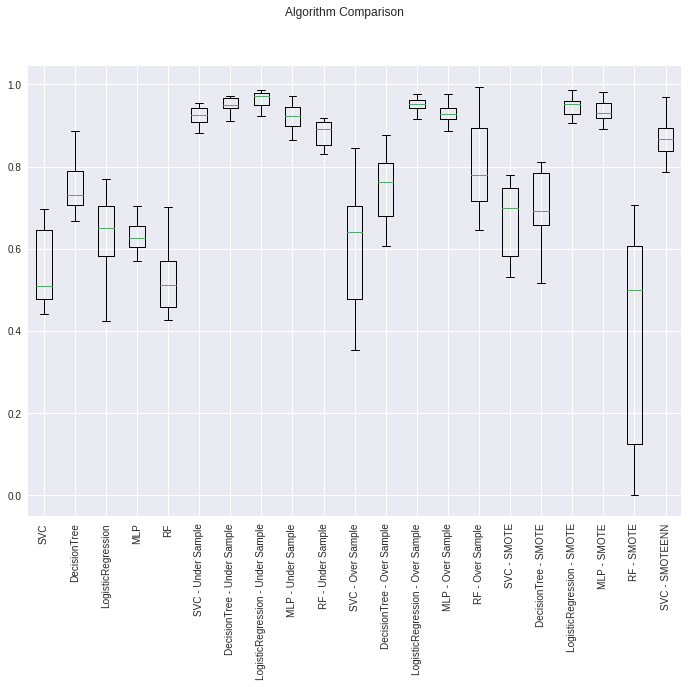

DecisionTree
SMOTEENN
------------
              precision    recall  f1-score   support

           0       0.39      0.69      0.50        87
           1       0.98      0.95      0.97      1843

   micro avg       0.94      0.94      0.94      1930
   macro avg       0.69      0.82      0.73      1930
weighted avg       0.96      0.94      0.95      1930

Matthews correlation coefficient
0.4871379754796301
G-mean
0.8087681600572321


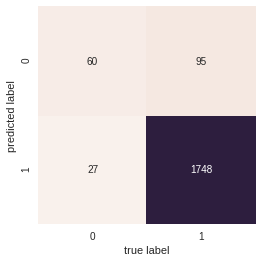

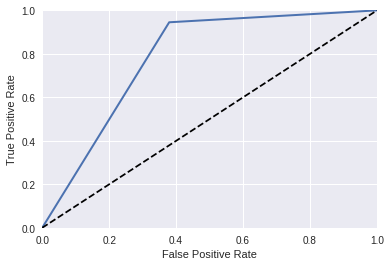

AUC: 0.782944
Score do conjunto de testes: 0.844393 (0.056486) 



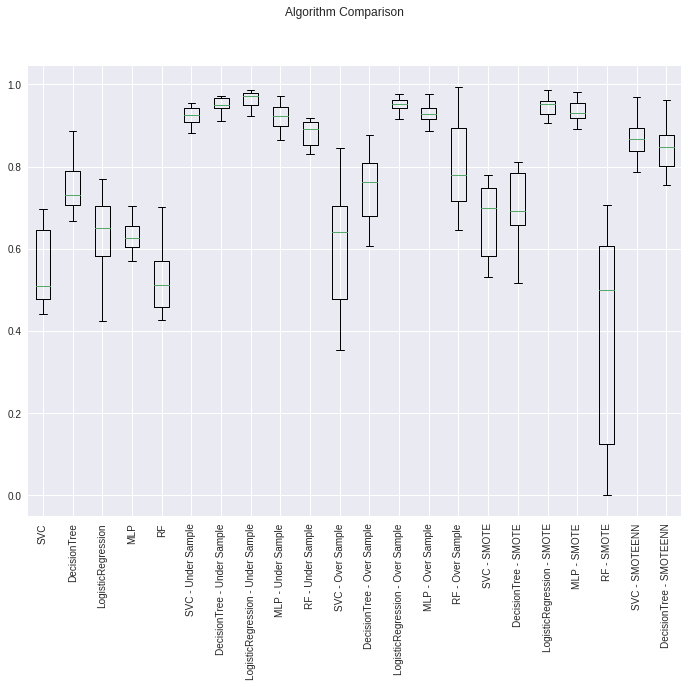

LogisticRegression
SMOTEENN
------------------
              precision    recall  f1-score   support

           0       0.22      0.82      0.35        87
           1       0.99      0.86      0.92      1843

   micro avg       0.86      0.86      0.86      1930
   macro avg       0.61      0.84      0.63      1930
weighted avg       0.96      0.86      0.90      1930

Matthews correlation coefficient
0.3783528336506019
G-mean
0.8396115652306876


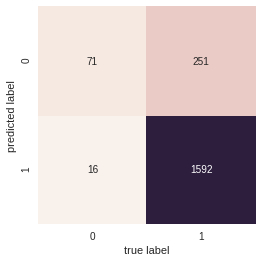

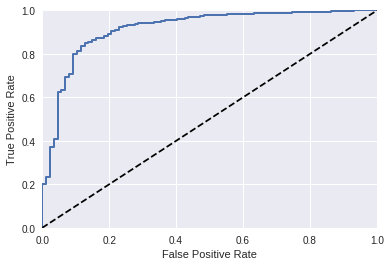

AUC: 0.915611
Score do conjunto de testes: 0.934440 (0.023522) 



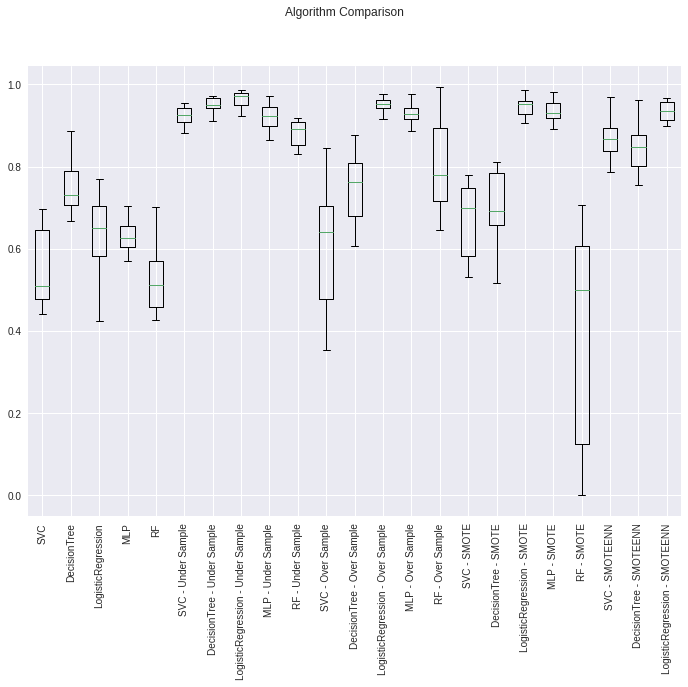

MLP
SMOTEENN
---
              precision    recall  f1-score   support

           0       0.21      0.84      0.34        87
           1       0.99      0.85      0.92      1843

   micro avg       0.85      0.85      0.85      1930
   macro avg       0.60      0.85      0.63      1930
weighted avg       0.96      0.85      0.89      1930

Matthews correlation coefficient
0.3766120102313253
G-mean
0.846528336477357


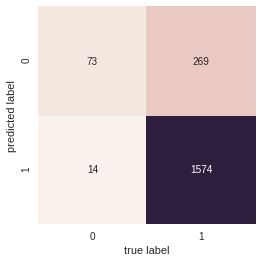

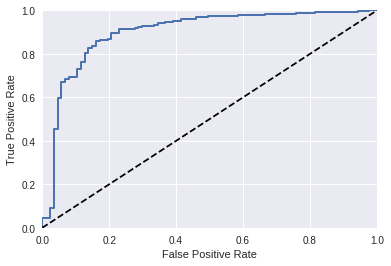

AUC: 0.898485
Score do conjunto de testes: 0.935515 (0.022626) 



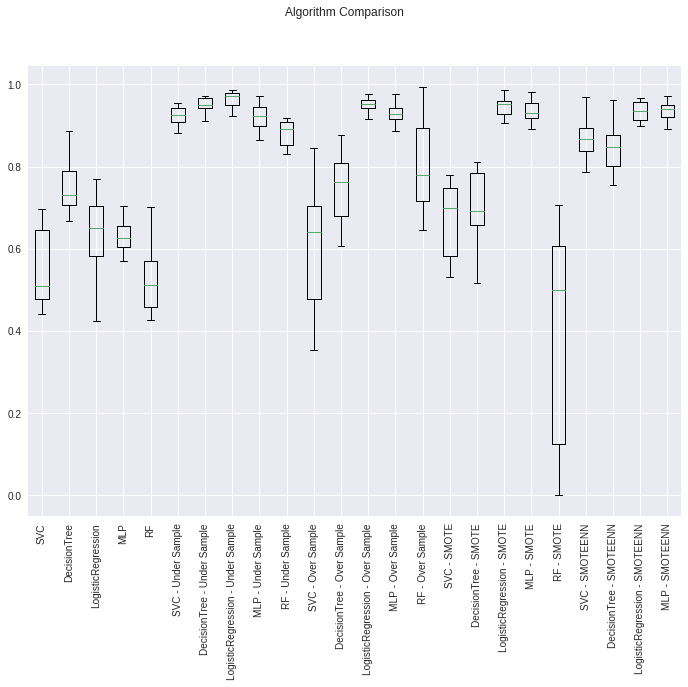

RF
SMOTEENN
--
              precision    recall  f1-score   support

           0       0.42      0.64      0.51        87
           1       0.98      0.96      0.97      1843

   micro avg       0.94      0.94      0.94      1930
   macro avg       0.70      0.80      0.74      1930
weighted avg       0.96      0.94      0.95      1930

Matthews correlation coefficient
0.49084941324017006
G-mean
0.7851345236999032


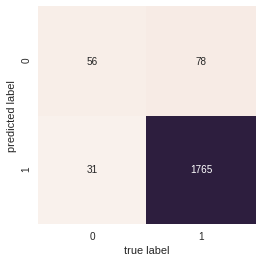

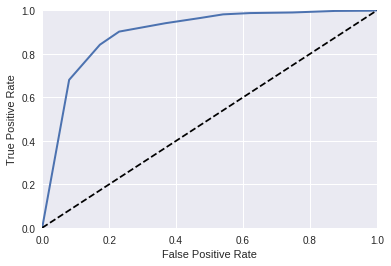

AUC: 0.896383
Score do conjunto de testes: 0.902626 (0.035181) 



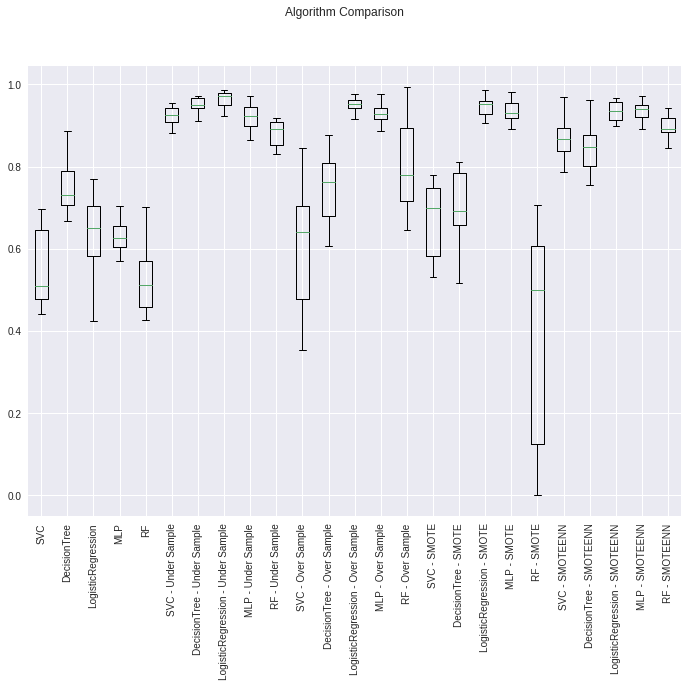

SVC
SMOTETomek
---
              precision    recall  f1-score   support

           0       0.52      0.41      0.46        87
           1       0.97      0.98      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.75      0.70      0.72      1930
weighted avg       0.95      0.96      0.95      1930

Matthews correlation coefficient
0.4423808995872639
G-mean
0.6374824658962939


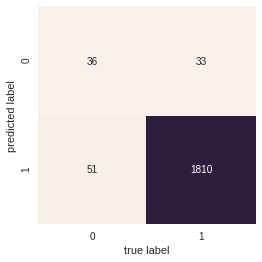

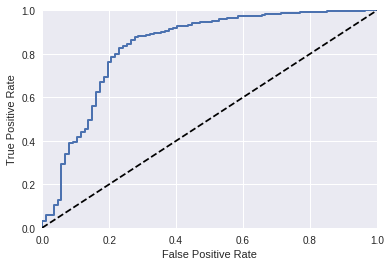

AUC: 0.833361
Score do conjunto de testes: 0.664102 (0.081311) 



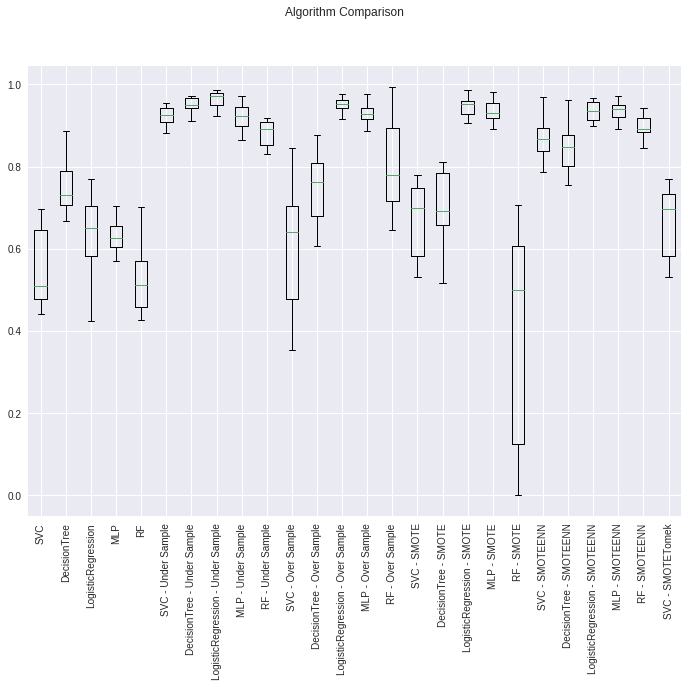

DecisionTree
SMOTETomek
------------
              precision    recall  f1-score   support

           0       0.56      0.55      0.55        87
           1       0.98      0.98      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.77      0.77      0.77      1930
weighted avg       0.96      0.96      0.96      1930

Matthews correlation coefficient
0.534039616367339
G-mean
0.7350839288882434


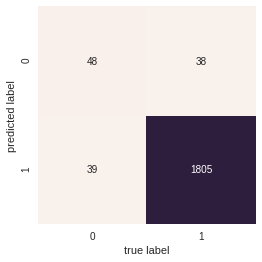

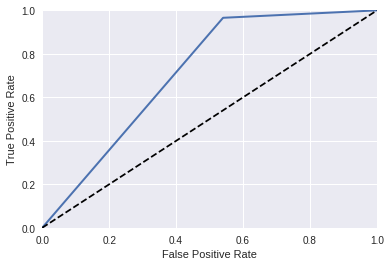

AUC: 0.712793
Score do conjunto de testes: 0.696827 (0.062059) 



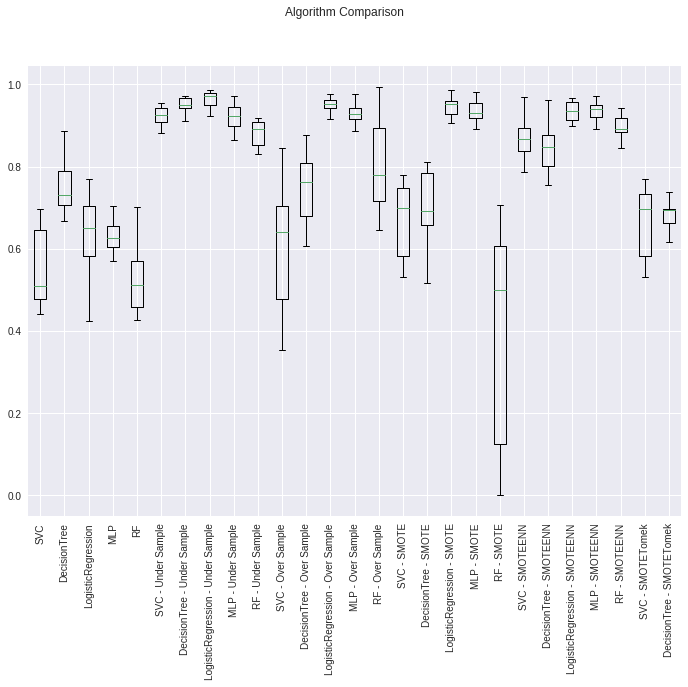

LogisticRegression
SMOTETomek
------------------
              precision    recall  f1-score   support

           0       0.25      0.79      0.38        87
           1       0.99      0.88      0.93      1843

   micro avg       0.88      0.88      0.88      1930
   macro avg       0.62      0.84      0.65      1930
weighted avg       0.96      0.88      0.91      1930

Matthews correlation coefficient
0.3988739240513602
G-mean
0.8377785407953686


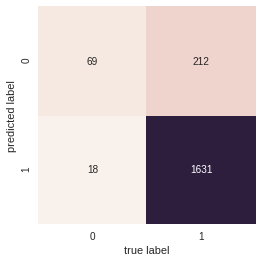

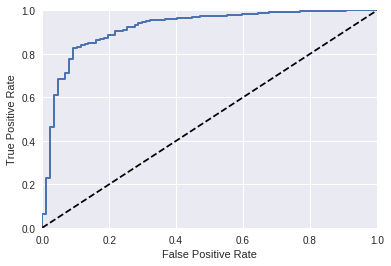

AUC: 0.919865
Score do conjunto de testes: 0.944520 (0.022656) 



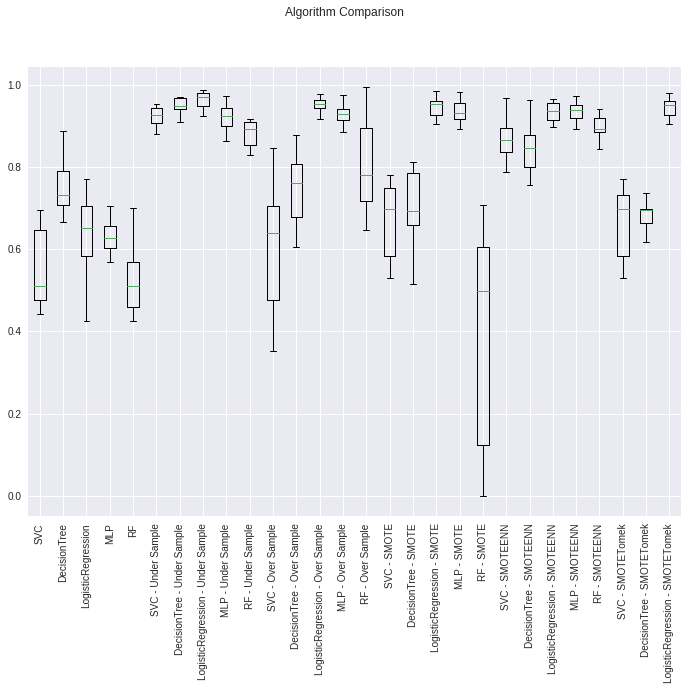

MLP
SMOTETomek
---
              precision    recall  f1-score   support

           0       0.25      0.83      0.38        87
           1       0.99      0.88      0.93      1843

   micro avg       0.88      0.88      0.88      1930
   macro avg       0.62      0.86      0.66      1930
weighted avg       0.96      0.88      0.91      1930

Matthews correlation coefficient
0.41365079315529163
G-mean
0.8547472865304019


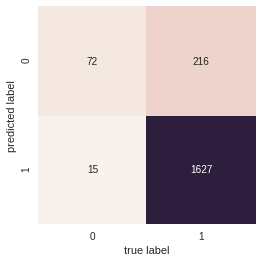

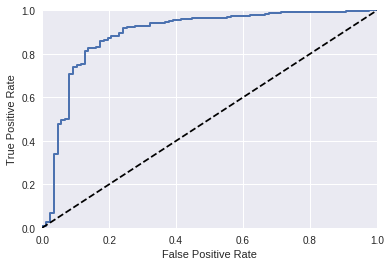

AUC: 0.892055
Score do conjunto de testes: 0.928785 (0.025523) 



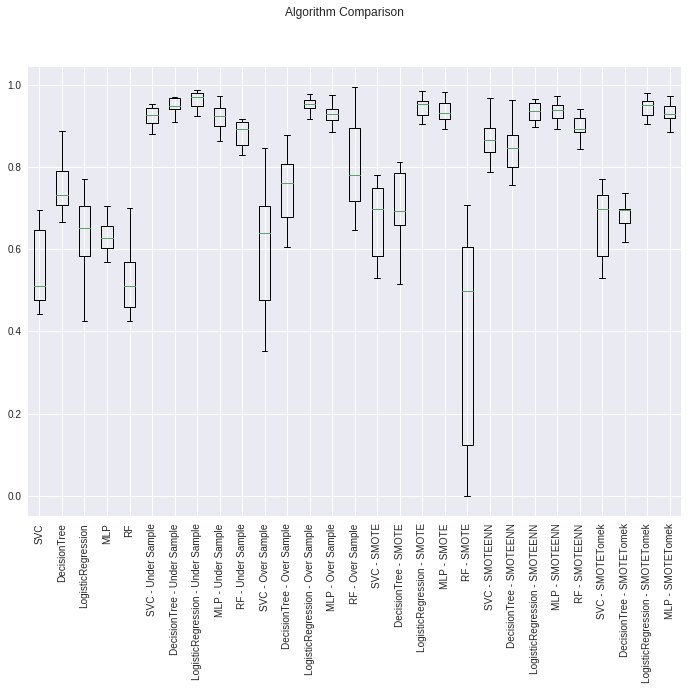

RF
SMOTETomek
--
              precision    recall  f1-score   support

           0       0.66      0.36      0.46        87
           1       0.97      0.99      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.81      0.67      0.72      1930
weighted avg       0.96      0.96      0.96      1930

Matthews correlation coefficient
0.46792728829179503
G-mean
0.5943302380869608


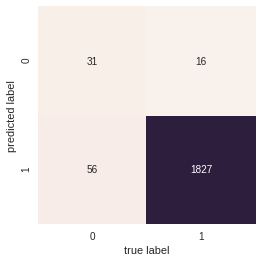

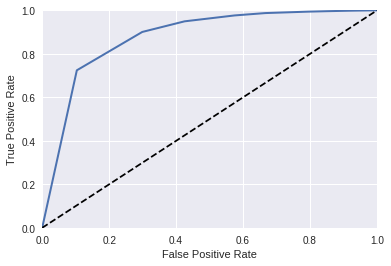

AUC: 0.879070
Score do conjunto de testes: 0.492908 (0.361760) 



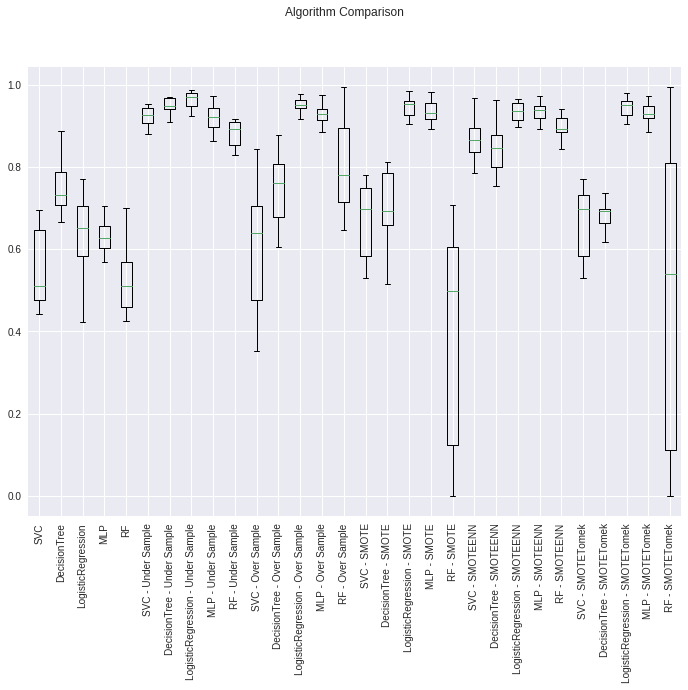

['SVC', 'DecisionTree', 'LogisticRegression', 'MLP', 'RF', 'SVC - Under Sample', 'DecisionTree - Under Sample', 'LogisticRegression - Under Sample', 'MLP - Under Sample', 'RF - Under Sample', 'SVC - Over Sample', 'DecisionTree - Over Sample', 'LogisticRegression - Over Sample', 'MLP - Over Sample', 'RF - Over Sample', 'SVC - SMOTE', 'DecisionTree - SMOTE', 'LogisticRegression - SMOTE', 'MLP - SMOTE', 'RF - SMOTE', 'SVC - SMOTEENN', 'DecisionTree - SMOTEENN', 'LogisticRegression - SMOTEENN', 'MLP - SMOTEENN', 'RF - SMOTEENN', 'SVC - SMOTETomek', 'DecisionTree - SMOTETomek', 'LogisticRegression - SMOTETomek', 'MLP - SMOTETomek', 'RF - SMOTETomek']
[array([0.49867549, 0.        , 0.44243042, 0.67048523, 0.57114202,
       0.52079629, 0.67368105, 0.5       , 0.69567034, 0.47012179]), array([0.70147237, 0.30923844, 0.8872621 , 0.72627304, 0.8010688 ,
       0.66674991, 0.72971134, 0.75313953, 0.80550689, 0.73310273]), array([0.70710678, 0.546224  , 0.77046546, 0.4240521 , 0.57114202,
      

In [9]:
#function test all balance config
def test_all_balance(models, balanced_tecn, name_balanced_tecn, Xtrain, ytrain, Xtest, ytest, results, names):
  for model in models:
    print(model['name'])
    print(name_balanced_tecn)
    print('-'*len(model['name']))
 
    sample = make_imb_pipeline(balanced_tecn, clone(model['best_model']))

    #treino
    sample.fit(Xtrain, ytrain)

    #predicao
    ypred = sample.predict(Xtest)

    #avaliação 
    evaluating(sample, ytest, ypred, Xtest)

    cv_results = model_selection.cross_val_score(sample, Xtest, ypred, 
                                                 cv=model_selection.KFold(
                                                     n_splits=10, random_state=42),
                                                     scoring=make_scorer(geometric_mean_score))

    results.append(cv_results)
    names.append(model['name']+' - '+name_balanced_tecn)

    msg = "Score do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
    print(msg)

    # boxplot algorithm comparison
    plot_alg_comp(results, names)

test_all_balance(res_models, RandomUnderSampler(random_state=42), "Under Sample", Xtrain, ytrain, Xtest, ytest, results, names)
test_all_balance(res_models, RandomOverSampler(random_state=42), "Over Sample", Xtrain, ytrain, Xtest, ytest, results, names)
test_all_balance(res_models, SMOTE(random_state=42), "SMOTE", Xtrain, ytrain, Xtest, ytest, results, names)
#test_all_balance(res_models, EditedNearestNeighbours(random_state=42, n_neighbors=5), "ENN", Xtrain, ytrain, Xtest, ytest, results, names)
#test_all_balance(res_models, CondensedNearestNeighbour(random_state=42), "CNN", Xtrain, ytrain, Xtest, ytest, results, names)
test_all_balance(res_models, SMOTEENN(random_state=42), "SMOTEENN", Xtrain, ytrain, Xtest, ytest, results, names)
test_all_balance(res_models, SMOTETomek(random_state=42), "SMOTETomek", Xtrain, ytrain, Xtest, ytest, results, names)

print(names)
print(results)

##Utilizando técnicas robustas ao desbalanceamento

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.2min finished


{'n_estimators': 200}
0.8717319715735887
              precision    recall  f1-score   support

           0       0.27      0.84      0.41        87
           1       0.99      0.89      0.94      1843

   micro avg       0.89      0.89      0.89      1930
   macro avg       0.63      0.87      0.68      1930
weighted avg       0.96      0.89      0.92      1930

Matthews correlation coefficient
0.43995280703640416
G-mean
0.866199123274651


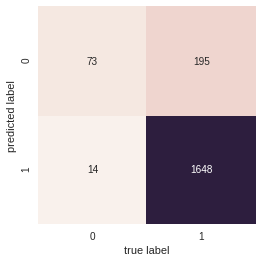

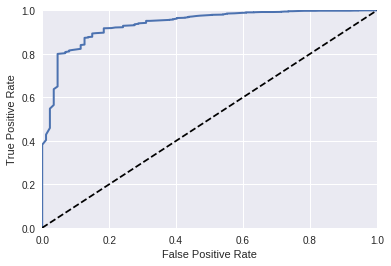

AUC: 0.937053
Score do conjunto de testes: 0.974226 (0.016296) 



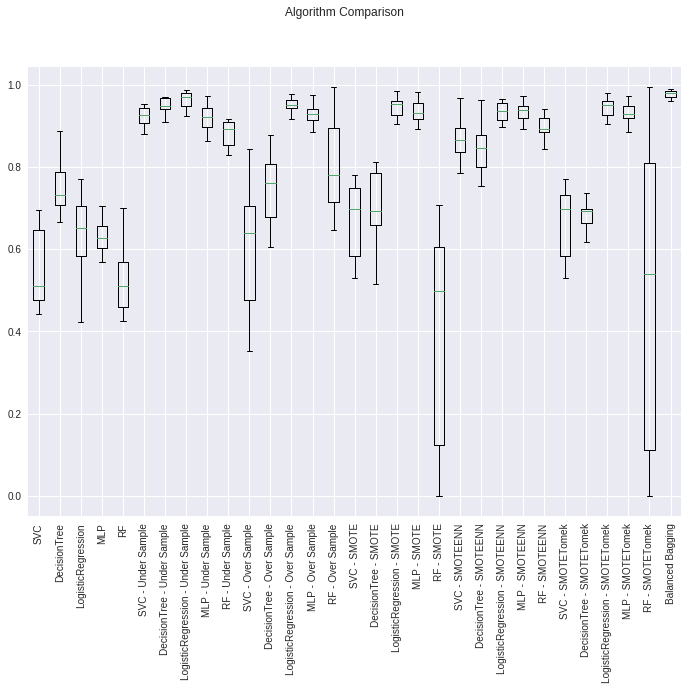

In [10]:
#BalancedBaggingClassifier

#classificador base DT
tree = DecisionTreeClassifier(max_features='auto')

#otimiza parâmetros
parameters = {'n_estimators': (10, 30, 100, 200, 300)}

grid = GridSearchCV(BalancedBaggingClassifier(base_estimator=tree),
                    param_grid=parameters,
                    cv=10, 
                    verbose=1,
                    n_jobs = -1,
                    scoring=make_scorer(geometric_mean_score))
                    #scoring='recall_macro')
                    #scoring='accuracy')

#treina
grid.fit(Xtrain, ytrain)

#exibe melhor modelo
print(grid.best_params_)
print(grid.best_score_)
ensemble = grid.best_estimator_

#predicao
ypred_ensemble = ensemble.predict(Xtest)

#avaliacao
evaluating(ensemble, ytest, ypred_ensemble, Xtest)

cv_results = model_selection.cross_val_score(ensemble, Xtest, ypred_ensemble, 
                                             cv=model_selection.KFold(
                                                 n_splits=10, random_state=42),
                                                 scoring=make_scorer(geometric_mean_score))
                                             #scoring='recall_macro')
                                             #scoring='accuracy')

results.append(cv_results)
names.append('Balanced Bagging')

msg = "Score do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
print(msg)

# boxplot algorithm comparison
plot_alg_comp(results, names)

## Teste de p-value, a fim de confirmar se os desempenhos são diferentes

In [11]:
#test p-value 
from scipy.stats import ttest_ind

print(results)

alpha = 0.05

i = 0
for r1 in results:
    j = 0
    for r2 in results:
      tmp = names[i]+" x "+names[j]
      print(tmp)
      print('-'*len(tmp))
      
      
      stat, p = ttest_ind(r1, r2)
      print('Statistics=%.3f, p=%.3f' % (stat, p))
      # interpret
      if p > alpha:
        print('Same distributions (fail to reject H0)')
      else:
        print('Different distributions (reject H0)')
      
      j = j+1 
      
    i = i+1
    

[array([0.49867549, 0.        , 0.44243042, 0.67048523, 0.57114202,
       0.52079629, 0.67368105, 0.5       , 0.69567034, 0.47012179]), array([0.70147237, 0.30923844, 0.8872621 , 0.72627304, 0.8010688 ,
       0.66674991, 0.72971134, 0.75313953, 0.80550689, 0.73310273]), array([0.70710678, 0.546224  , 0.77046546, 0.4240521 , 0.57114202,
       0.73651717, 0.62017367, 0.64012545, 0.69950326, 0.66120955]), array([0.70523365, 0.63245553, 0.6205694 , 0.        , 0.69374594,
       0.59970022, 0.61498384, 0.64192103, 0.56957939, 0.66120955]), array([0.5       , 0.44476309, 0.77046546, 0.52223297, 0.70141187,
       0.42640143, 0.55160992, 0.5       , 0.        , 0.57577925]), array([0.90728757, 0.94758231, 0.88071257, 0.92183705, 0.90811388,
       0.9067647 , 0.95450978, 0.9305099 , 0.92980777, 0.95058638]), array([0.94727836, 0.96867531, 0.92117147, 0.94296829, 0.96499502,
       0.94102457, 0.97152781, 0.96803866, 0.91003151, 0.95136476]), array([0.93374336, 0.96804283, 0.94764793, 0.98

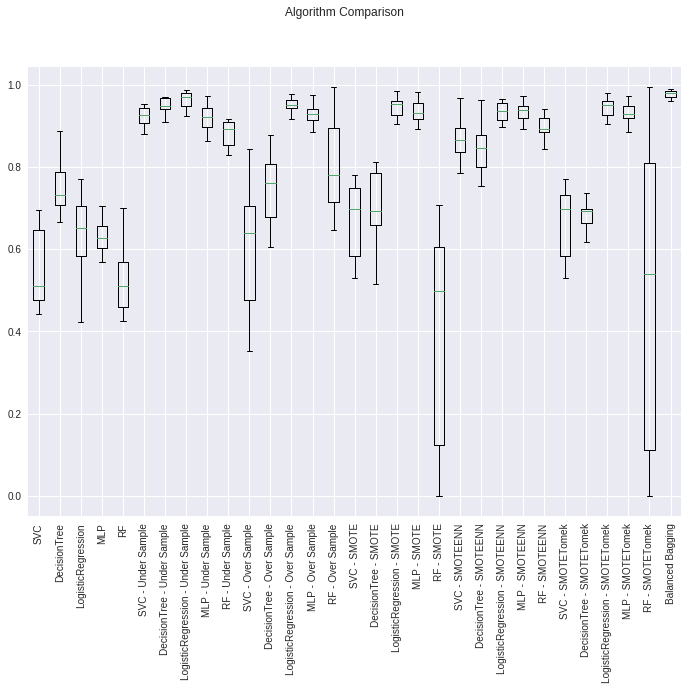

In [12]:
# boxplot algorithm comparison
plot_alg_comp(results, names)